# 0. Magic Commands


In [140]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# 1. Import Library

In [141]:
from fastai import *
from fastai.vision import *
from fastai.metrics import accuracy
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

# 2. ข้อมูล

Camvid

In [142]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/home/jupyter/.fastai/data/camvid/valid.txt'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels'),
 PosixPath('/home/jupyter/.fastai/data/camvid/codes.txt')]

In [143]:
path_labels = path/'labels'
path_images = path/'images'

In [144]:
filenames = get_image_files(path_images)
filenames[:3]

[PosixPath('/home/jupyter/.fastai/data/camvid/images/0006R0_f01020.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images/0016E5_06390.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images/Seq05VD_f01830.png')]

In [145]:
label_names = get_image_files(path_labels)
label_names[:3]

[PosixPath('/home/jupyter/.fastai/data/camvid/labels/0006R0_f02340_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/0016E5_01230_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/0001TP_009150_P.png')]

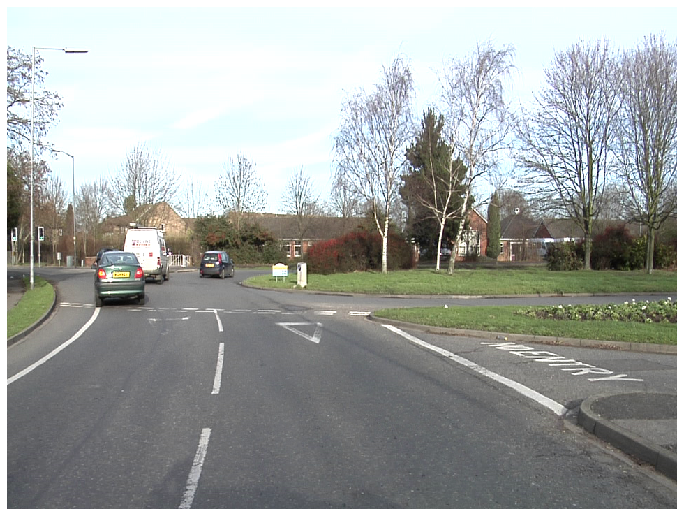

In [146]:
image_file = filenames[0]
image = open_image(image_file)
image.show(figsize=(12,12))

In [147]:
get_y_fn = lambda x: path_labels/f'{x.stem}_P{x.suffix}'

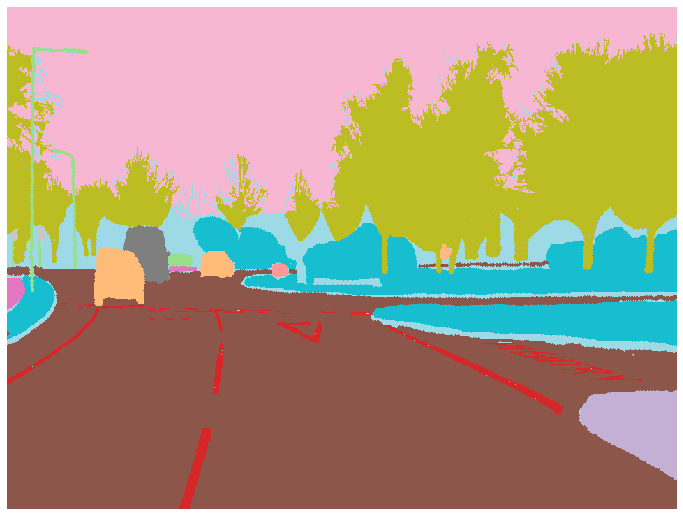

In [148]:
mask = open_mask(get_y_fn(image_file))
mask.show(figsize=(12,12), alpha=1)

In [149]:
source_size = np.array(mask.shape[1:])
source_size, mask.data

(array([720, 960]), tensor([[[21, 21, 21,  ..., 21, 21, 21],
          [21, 21, 21,  ..., 21, 21, 21],
          [21, 21, 21,  ..., 21, 21, 21],
          ...,
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17]]]))

In [150]:
codes = np.loadtxt(path/'codes.txt', dtype=str)
codes


array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

# Datasets

In [151]:
size = source_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=4, have 0MB of GPU RAM free


In [152]:
labellists = (SegmentationItemList.from_folder(path_images)
              .split_by_fname_file('../valid.txt')
              .label_from_func(get_y_fn, classes=codes))

In [153]:
databunch = (labellists.transform(get_transforms(), size=size, tfm_y=True)
             .databunch(bs=bs)
             .normalize(imagenet_stats))

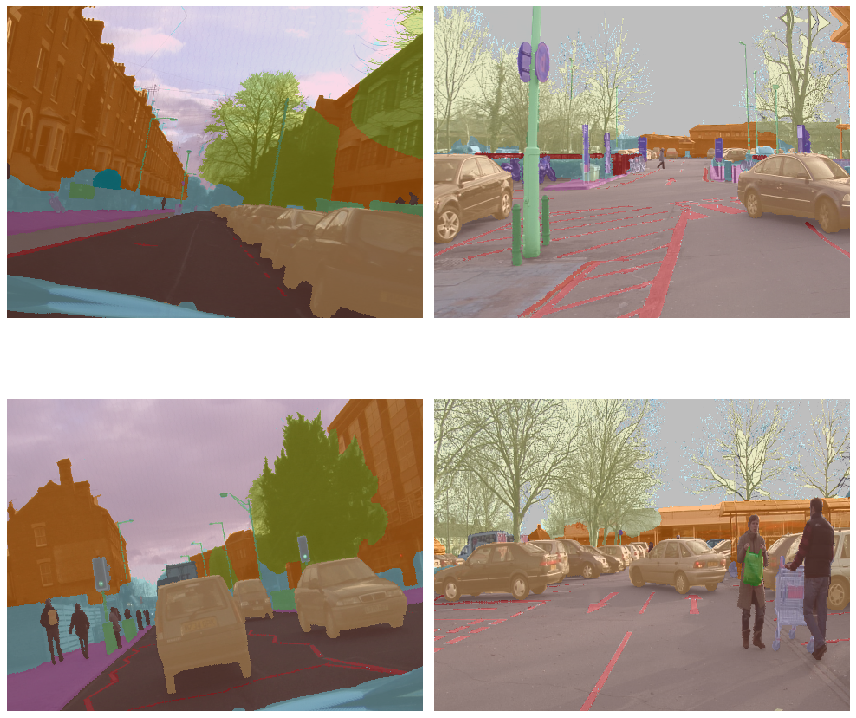

In [154]:
databunch.show_batch(3, figsize=(12, 12))

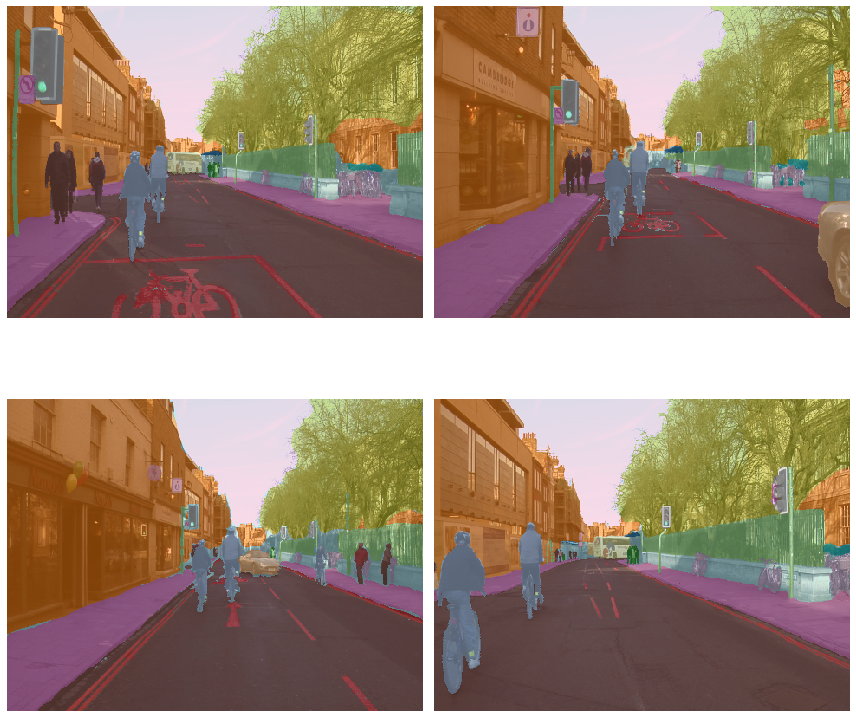

In [155]:
databunch.show_batch(2, figsize=(12, 12), ds_type=DatasetType.Valid)

# Model

In [176]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [177]:
metrics=acc_camvid
# metrics=accuracy

In [178]:
wd=1e-2

In [179]:
learner = unet_learner(databunch, models.resnet34, metrics=metrics, wd=wd).to_fp16()


In [180]:
lr=3e-3

In [ ]:
learner.fit_one_cycle(10, slice(lr), pct_start=0.9)

In [181]:
learner.save('unet-resnet34-1')

In [182]:
learner.load('unet-resnet34-1');

In [ ]:
learner.show_results(rows=3, figsize=(12, 12))

# เทรนต่อ

In [183]:
learner.unfreeze()


In [184]:
lrs = slice(lr/400,lr/4)


In [ ]:
learner.fit_one_cycle(12, lrs, pct_start=0.8)


In [185]:
learner.save('unet-resnet34-2')


In [186]:
learner.load('unet-resnet34-2');


# เทรนต่อ 2

In [187]:
learner.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

this Learner object self-destroyed - it still exists, but no longer usable
using bs=1, have 0MB of GPU RAM free


In [188]:
databunch = (labellists.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [189]:
learner = unet_learner(databunch, models.resnet34, metrics=metrics, wd=wd)


In [190]:
learner.load('unet-resnet34-2');
learner.to_fp16().freeze()

In [ ]:
lr=1e-3
learner.fit_one_cycle(10, slice(lr), pct_start=0.8)


In [191]:
learner.save('unet-resnet34-720-1')

In [192]:
learner.load('unet-resnet34-720-1');

In [193]:
learner.unfreeze()

In [ ]:
lrs = slice(1e-6,lr/10)
learner.fit_one_cycle(10, lrs)

In [194]:
learner.save('unet-resnet34-720-2')


In [195]:
learner.load('unet-resnet34-720-2');

In [ ]:
learner.show_results(rows=3, figsize=(10,10))
